[Seaborn](https://seaborn.pydata.org/) is a Python data visualization library. It provides a high-level interface for drawing attractive and informative statistical graphics.

[`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) minimizes scalar function of one or more variables.


In [359]:
import math as mt
import latexify
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.optimize as so
seed = 0
np.random.seed(seed)


## Load the data and take a sneak peek


In [333]:
filename="Lab_W3_Data.csv"
# Loading the running speed dataset and drop "Unnamed: 0". Feature "age" is in [yrs] and "pace" in [min/km]
data = pd.read_csv(filename).drop("Unnamed: 0", axis=1)

data.head()


,age,pace
0,38,3.73
1,75,7.53
2,35,4.73
3,27,4.26
4,54,5.40


## 1D Distribution Plots


A histogram aims to approximate the underlying probability density function that generated the data by binning and counting observations.


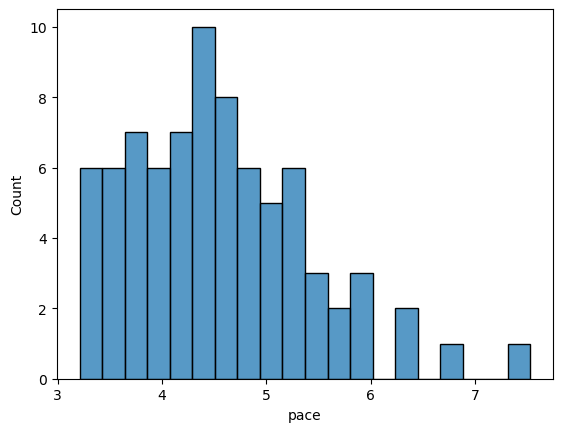

In [334]:
# Histogram
sns.histplot(data=data, x="pace", bins=20)
plt.show()


Kernel density estimation (KDE) presents a different solution to what histogram does. Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate


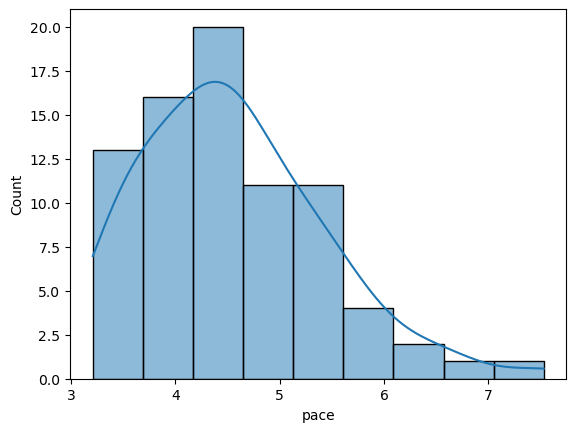

In [335]:
# Histogram and Density
sns.histplot(data=data, x="pace", kde=True)
plt.show()


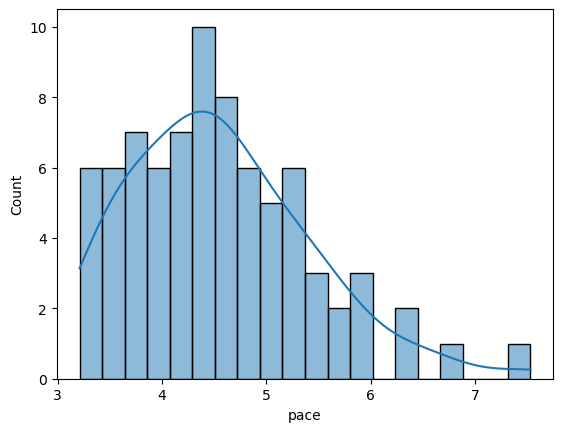

In [336]:
# Histogram and Density - specify # bins
sns.histplot(data=data, x="pace", bins=20, kde=True)
plt.show()


## 2D Joint Plots


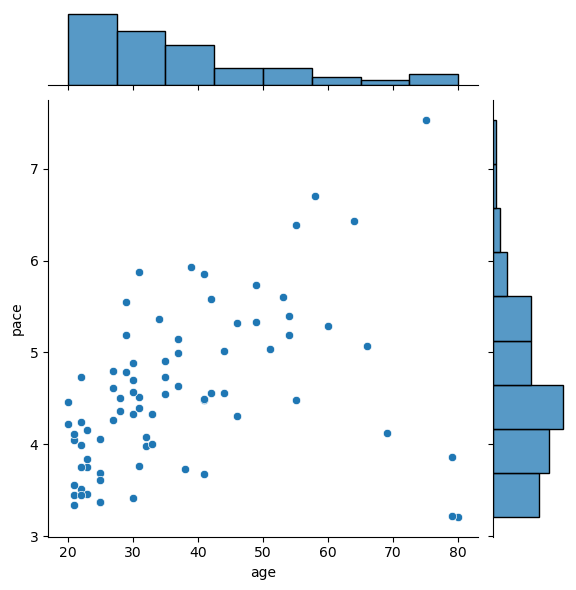

In [337]:
# Joint distribution plot
sns.jointplot(data=data, x="age", y="pace")
plt.show()


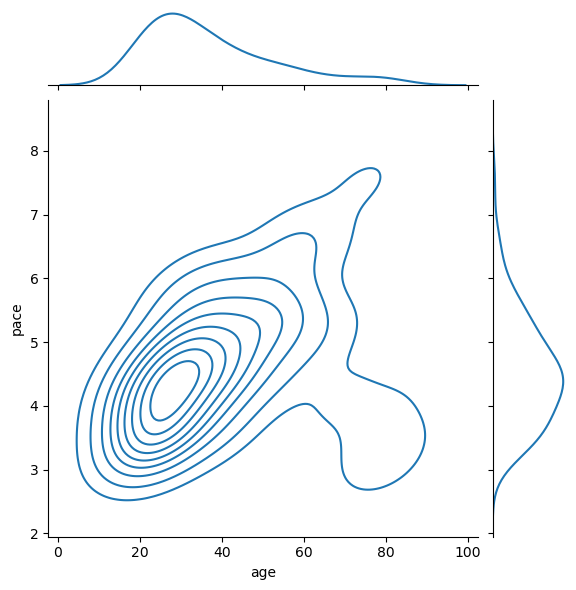

In [338]:
# Joint distribution plot with estimated density
sns.jointplot(data=data, x="age", y="pace", kind="kde")
plt.show()


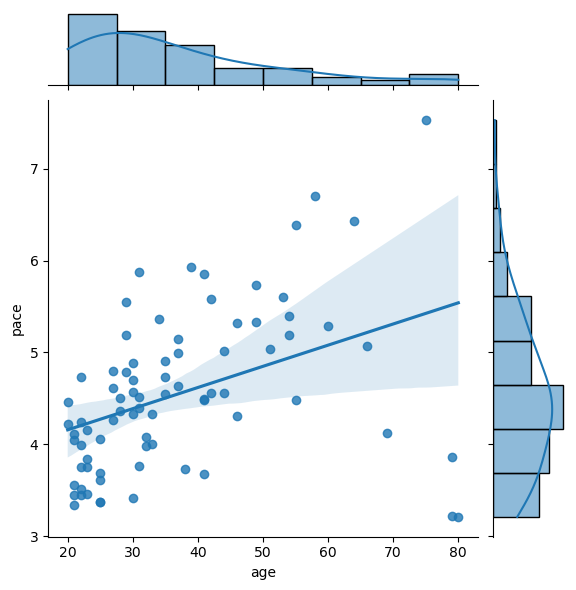

In [339]:
# Joint distribution plot with regression line
sns.jointplot(data=data, x="age", y="pace", kind="reg")
plt.show()


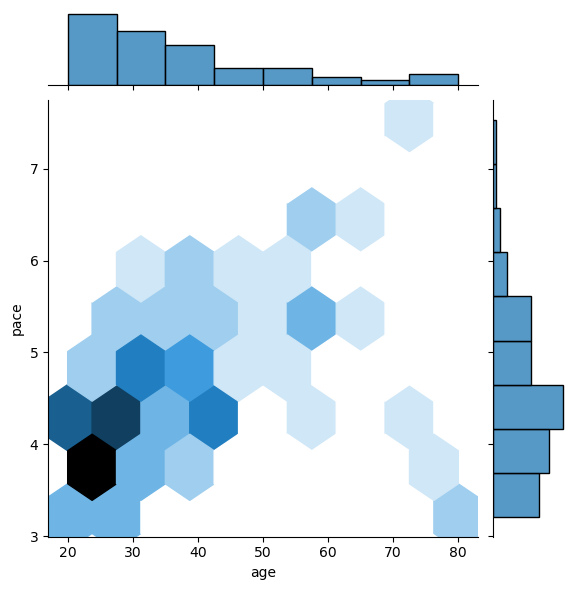

In [340]:
# Joint distribution plot with hexagons
sns.jointplot(data=data, x="age", y="pace", kind="hex")
plt.show()


Please peruse [Visualizing Distributions of Data](https://seaborn.pydata.org/tutorial/distributions.html#), and try your hands on different options you see in there.


## Maximum Likelihood Example - Laplace Distribution


In [341]:
# Generate data
n = 10001
normalData = pd.DataFrame({"NormalData": np.random.normal(0, 1, n)})
laplaceData = pd.DataFrame({"LaplaceData": np.random.laplace(0, 1, n)})

# concatenation
df = pd.concat([normalData, laplaceData], axis=1)
df.tail()


,NormalData,LaplaceData
9996,0.042359,-0.288242
9997,0.516872,0.100169
9998,-0.032921,-0.167123
9999,1.298111,-1.988670
10000,-0.202117,0.592340


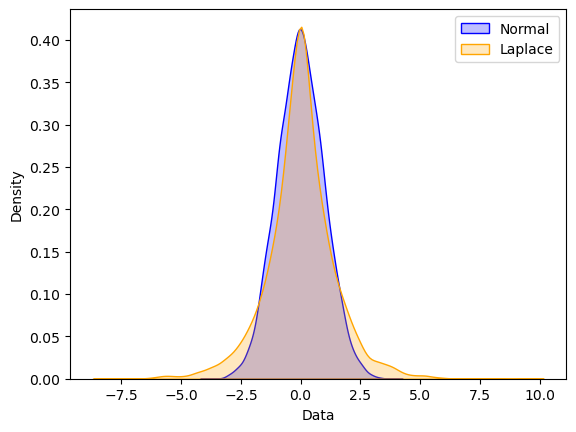

In [342]:
# Plot
sns.kdeplot(df['NormalData'], fill=True, color='Blue', label='Normal')
sns.kdeplot(df['LaplaceData'], fill=True, color='Orange', label='Laplace')
plt.xlabel('Data')
plt.legend()
plt.show()


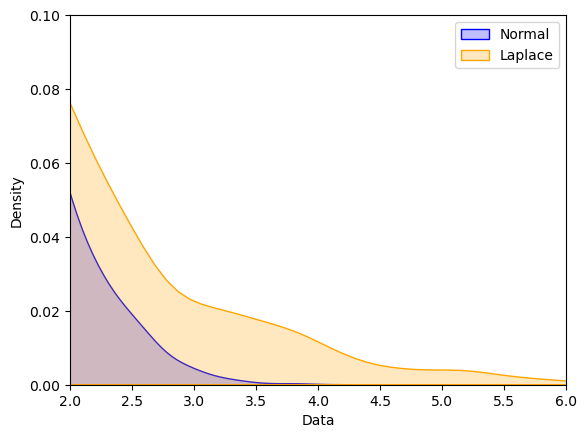

In [343]:
#Zoom in
sns.kdeplot(df['NormalData'], fill=True, color='Blue', label='Normal')
sns.kdeplot(df['LaplaceData'], fill=True, color='Orange', label='Laplace')
plt.xlabel('Data')
plt.xlim(2,6)
plt.ylim(0,0.1)
plt.legend()
plt.show()
# You see more extreme values with Laplace even with the same variance. The Laplace
# distribution is useful for modeling data where more extreme values are expected.


The likelihood of the data is the product of the probability density function evaluated at each one of the data points. So, we really want to know what is the probability density function of the [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution).

Negative, because Scipy gives us a minimization function. So we are going to minimize the negative log likelihood to get the maximum log likelihood. Recall: We do log to avoid getting underflow to zero.


In [344]:
# Laplace Negative Log Likelihood
def laplaceNegLogLikelihood(mu, b, y):
    neg_log_lik = -(-np.log(2*b)-(1/b)*np.sum(abs(y-mu)))
    return neg_log_lik

@latexify.function
def L(mu, b, y):
    return -(-log(2*b)-(1/b)*sum(abs(y-mu)))
L


Develop a maximum likelihood function that takes a set of data and produces the maximum likelihood estimate for the mean of those data:


In [345]:
## Laplace Maximum Likelihood Estimate for mu
def maximumLikelihood(y):
    RES = so.minimize(laplaceNegLogLikelihood, 1, args=(1, y), method="Powell", tol = 1e-8) # Powell works better for functions that are not differentiable everywhere
    # print(RES)
    return RES.x

# Test the function
maximumLikelihood(df.LaplaceData.values)


array([0.00219743])

which is very close to zero set for the original data.


In [346]:
# Minimizing the sum of absolute differences should be the same as median:
round(df.LaplaceData.median(),4)


0.0022

In [347]:
# Laplace Negative Log Likelihood for regression
def laplaceRegNegLogLikelihood(beta, X, y):
    mu = (X@beta).reshape(-1,1) # compute the mean that we would have if assumed that the form of the function of the mean is beta times X
    return laplaceNegLogLikelihood(mu, 1, y)


So, now if we want the maximum likelihood estimated at the regression coefficients we are going to write a function that takes in the X's and the Y's and then optimizes `laplaceRegNegLogLikelihood` to find the betas that are the maximum likelihood estimates for vector beta.


In [348]:
# Function to maximize regression log likelihood
def maximumRegLikelihood(X, y, negloglik=laplaceRegNegLogLikelihood):
    nrows, ncols = X.shape
    betas=np.zeros((ncols,1)) # initialize vector beta
    RES = so.minimize(negloglik, np.squeeze(betas), args=(X,y), method="Powell", tol=1e-8)
    print(RES.x)
    return RES.x


Let's test this out:


In [349]:
run_data = pd.read_csv(filename).drop("Unnamed: 0", axis=1)
run_data.head()


,age,pace
0,38,3.73
1,75,7.53
2,35,4.73
3,27,4.26
4,54,5.40


In [350]:
x_train = run_data.age.values
X_train = np.c_[np.ones(x_train.size), x_train]
y_train = run_data.pace.values.reshape(-1,1)

betas = maximumRegLikelihood(X_train, y_train)


[3.33521739 0.03434783]


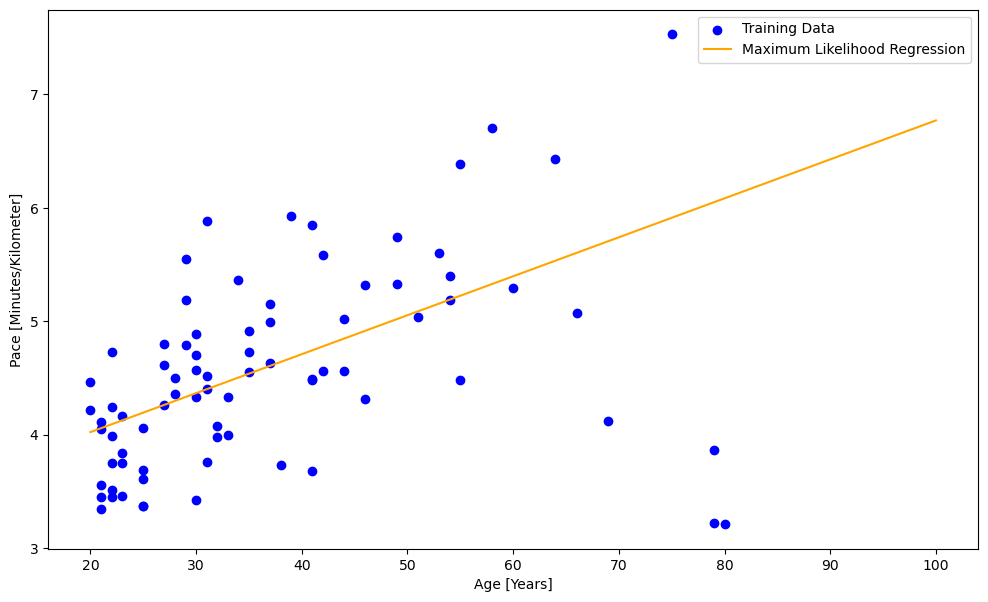

In [351]:
x_new = np.linspace(run_data.age.values.min(), run_data.age.values.max()+20, 100)
X_new = np.c_[np.ones(x_new.size), x_new]
y_predicted = X_new@betas

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
plt.scatter(x_train, y_train, c='blue', label='Training Data')
plt.plot(x_new, y_predicted, c='orange', label='Maximum Likelihood Regression')
plt.legend()
plt.xlabel("Age [Years]")
plt.ylabel("Pace [Minutes/Kilometer]")
plt.show()


Let's compare the data actual distributions against some ideal distributions:


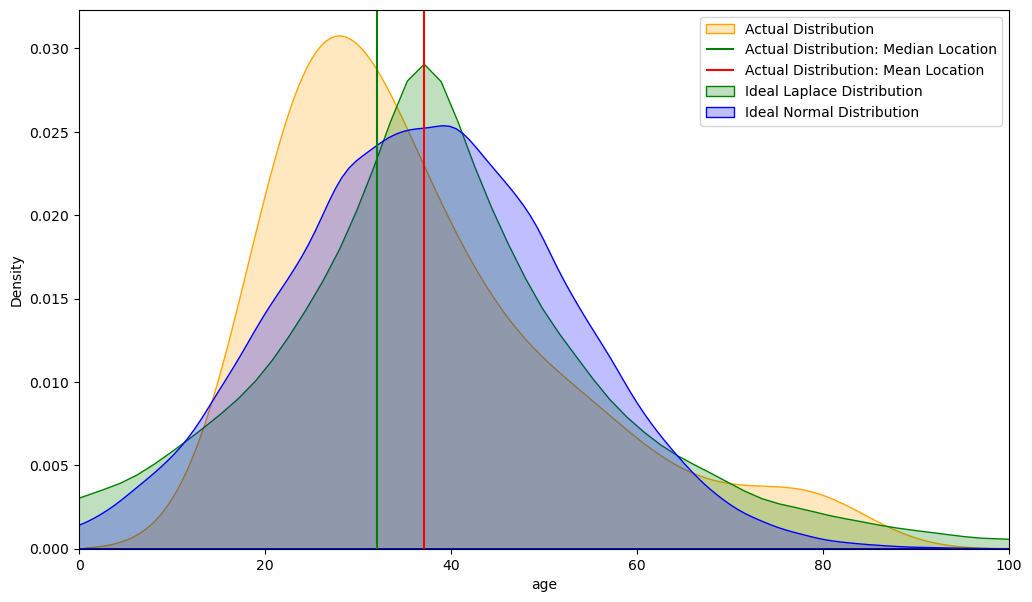

In [352]:
data = run_data['age']

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

sns.kdeplot(data, fill=True, color='Orange', label='Actual Distribution')
ylim = ax.get_ylim()
plt.vlines(data.median(), ylim[0], ylim[1], color='green', label='Actual Distribution: Median Location')
plt.vlines(data.mean(), ylim[0], ylim[1], color='red', label='Actual Distribution: Mean Location')

sns.kdeplot(np.random.laplace(data.mean(), data.std(), 100000), fill=True, color='Green', label='Ideal Laplace Distribution')
sns.kdeplot(np.random.normal(data.mean(), data.std(), 100000), fill=True, color='Blue', label='Ideal Normal Distribution')

plt.xlim(0,100)
plt.ylim(ylim)
plt.legend()
plt.show()


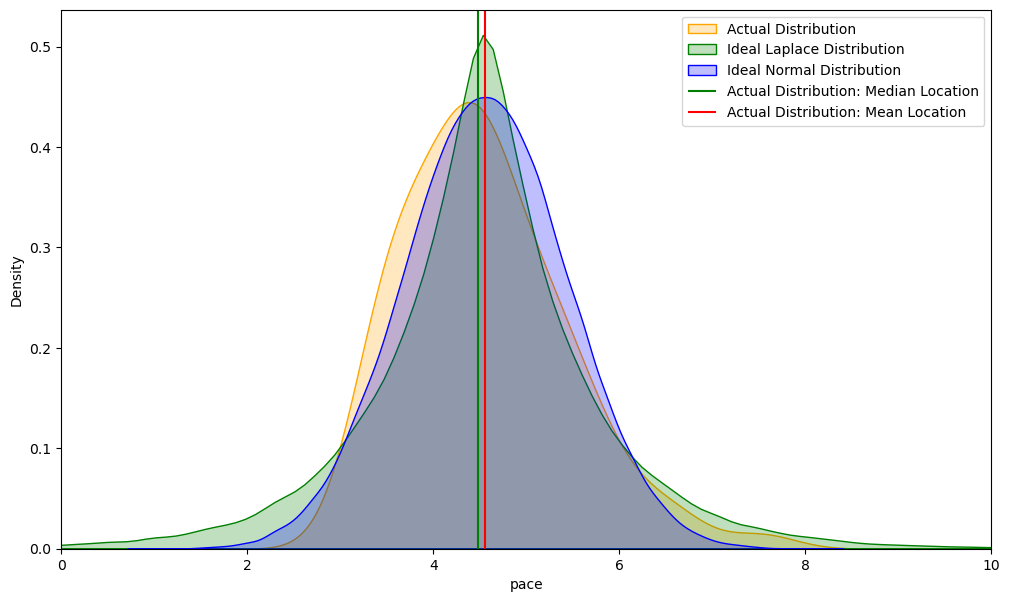

In [353]:
data = run_data['pace']

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)

sns.kdeplot(data, fill=True, color='Orange', label='Actual Distribution')
sns.kdeplot(np.random.laplace(data.mean(), data.std(), 100000), fill=True, color='Green', label='Ideal Laplace Distribution')
ylim = ax.get_ylim()
sns.kdeplot(np.random.normal(data.mean(), data.std(), 100000), fill=True, color='Blue', label='Ideal Normal Distribution')

plt.vlines(data.median(), ylim[0], ylim[1], color='green', label='Actual Distribution: Median Location')
plt.vlines(data.mean(), ylim[0], ylim[1], color='red', label='Actual Distribution: Mean Location')
plt.xlim(0,10)
plt.ylim(ylim)
plt.legend()
plt.show()


Which ideal distribution is a better choice to represent the actual data?


## Joint, Marginal, and Conditional Probability

|             | Marginal Probability                                                        | Joint Probability                                               | Conditional Probability                                                              |
| ----------- | --------------------------------------------------------------------------- | --------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| Definition  | The probability of an event occurring without considering any other events. | The probability of two or more events occurring simultaneously. | The probability of an event occurring given that another event has already occurred. |
| Calculation | $P(X=x)$                                                                    | $P(X=x,Y=y)$                                                    | $P(Y=y \mid X=x)$                                                                    |


### **Example:** Calculate Conditional Probability

Suppose we sent out a survey to 300 individuals asking them which sport they liked the best among baseball, basketball, football, and soccer, and we stored their responses in the dataframe below:


In [354]:
df = pd.DataFrame({'gender': np.repeat(np.array(['Male', 'Female']), 150),
                   'sport': np.repeat(np.array(['Baseball', 'Basketball', 'Football', 'Soccer',
                                                'Baseball', 'Basketball', 'Football', 'Soccer']),
                                                (34, 40, 58, 18, 34, 52, 20, 44))})

display(df)


,gender,sport
0,Male,Baseball
1,Male,Baseball
2,Male,Baseball
3,Male,Baseball
4,Male,Baseball
...,...,...
295,Female,Soccer
296,Female,Soccer
297,Female,Soccer
298,Female,Soccer


### Calculate the following:

**A)** $P(\text{Gender}=\text{Male} \mid \text{Sport}=\text{Baseball})$

**B)** $P(\text{Sport}=\text{Basketball} \mid \text{Gender}=\text{Female})$


In [355]:
c_table = pd.crosstab(index = df['gender'], columns=df['sport'], margins=True)
c_table


sport,Baseball,Basketball,Football,Soccer,All
gender,,,,,
Female,34,52,20,44,150
Male,34,40,58,18,150
All,68,92,78,62,300


In [358]:
# A) P(Gender = Male | Sport = Baseball)
print(str.format('A) {0:.2f}', c_table.iloc[1,0]/c_table.iloc[2,0]))

# B) P(Sport = Basketball | Gender = Female)
print(str.format('B) {0:.2f}', c_table.iloc[0, 1]/c_table.iloc[0,4]))


A) 0.50
B) 0.35
